# Preamble

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import time
import h5py
from astropy.io import fits

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Data

In [3]:
# load in data
from brutus.utils import magnitude, inv_magnitude
cluster_name = 'NGC_2682'
filename = '../data/benchmarks/' + cluster_name
f = fits.open(filename+'.fits')
fdata = f[1].data
Nobj = len(fdata)

In [4]:
### Info
info = np.empty(Nobj, dtype=[('GAIA_DR2_ID', int),
                             ('EBV', float),
                             ('feh_payne', float),
                             ('teff_payne', float),
                             ('logg_payne', float),
                             ('pmem', float),
                             ('parallax', float),
                             ('parallax_err', float)])
info['GAIA_DR2_ID'] = fdata['GAIA_DR2_ID']  # Gaia ID
info['EBV'] = fdata['EBV']  # Reddening
info['feh_payne'] = fdata['payne.feh']  # feh (Payne)
info['teff_payne'] = fdata['payne.teff']  # Teff (Payne)
info['logg_payne'] = fdata['payne.logg']  # logg (Payne)
info['pmem'] = fdata['HDBscan_MemProb']  # HDB P(member)

### Parallax (mas)
parallax, parallax_err = fdata['Parallax'], fdata['Parallax_Err']
psel = (np.isclose(parallax_err, 0.) | 
        np.isclose(parallax, 0.) | 
        (parallax_err > 1e6))  # safety screen
parallax[psel], parallax_err[psel] = np.nan, np.nan  # filler values
parallax_err = np.sqrt(parallax_err**2 + 0.04**2)  # 0.04 mas systematic offset
info['parallax'] = parallax
info['parallax_err'] = parallax_err

### Galactic coordinates (l, b)
coords = np.c_[fdata['l'], fdata['b']]

In [5]:
### Fluxes
# FLUXES MUST BE MAG=0 NORMALIZED (flux=10**-0.4*mag)

filters = []  # filter set
phot, err = np.zeros(Nobj), np.zeros(Nobj)  # fluxes, errors

# Gaia DR2
sys_err_gaia = np.array([0.02, 0.02, 0.02])
gaia_fnorm = np.array([18904273853.41611, 13788594503.310804, 
                       8036741508.0079975])  # zeropoints
gaia_flux = np.c_[fdata['gaia_dr2_source.phot_g_mean_flux'],
                  fdata['gaia_dr2_source.phot_bp_mean_flux'],
                  fdata['gaia_dr2_source.phot_rp_mean_flux']] / gaia_fnorm
gaia_err = np.c_[fdata['gaia_dr2_source.phot_g_mean_flux_error'],
                 fdata['gaia_dr2_source.phot_bp_mean_flux_error'],
                 fdata['gaia_dr2_source.phot_rp_mean_flux_error']] / gaia_fnorm
gaia_err[gaia_err <= 0.] = np.nan  # screen bad values
gaia_err = np.sqrt(gaia_err**2 + (sys_err_gaia * gaia_flux)**2)  # add floor
filters += brutus.filters.gaia
phot, err = np.c_[phot, gaia_flux], np.c_[err, gaia_err]

# SDSS
sys_err_sdss = np.array([0.05, 0.02, 0.02, 0.02, 0.02])
sdss_fnorm = np.array([963829000.0, 1000000200.0, 1000000200.0, 
                       1000000100.0, 1000000200.0])  # zeropoints
sdss_flux = fdata['sdss_dr14_starsweep.psfflux'] / sdss_fnorm
sdss_err = fdata['sdss_dr14_starsweep.psfflux_ivar']**-0.5 / sdss_fnorm
sdss_err[sdss_err <= 0.] = np.nan  # screen bad values
sdss_err = np.sqrt(sdss_err**2 + (sys_err_sdss * sdss_flux)**2)  # add floor
filters += brutus.filters.sdss
phot, err = np.c_[phot, sdss_flux], np.c_[err, sdss_err]

# PanSTARRS
sys_err_ps = np.array([0.02, 0.02, 0.02, 0.02, 0.02])
ps_flux, ps_err = fdata['ucal_fluxqz.median'], fdata['ucal_fluxqz.err']
ps_err[ps_err <= 0.] = np.nan  # screen bad values
ps_err = np.sqrt(ps_err**2 + (sys_err_ps * ps_flux)**2)  # add floor
filters += brutus.filters.ps
phot, err = np.c_[phot, ps_flux], np.c_[err, ps_err]

# DES
# sys_err_des = np.array([0.05, 0.02, 0.02, 0.02, 0.02])
# des_mag = np.c_[fdata['des_dr1_main.wavg_mag_psf_g'],
#                 fdata['des_dr1_main.wavg_mag_psf_r'],
#                 fdata['des_dr1_main.wavg_mag_psf_i'],
#                 fdata['des_dr1_main.wavg_mag_psf_z'],
#                 fdata['des_dr1_main.wavg_mag_psf_y']]
# des_magerr = np.c_[fdata['des_dr1_main.wavg_magerr_psf_g'],
#                    fdata['des_dr1_main.wavg_magerr_psf_r'],
#                    fdata['des_dr1_main.wavg_magerr_psf_i'],
#                    fdata['des_dr1_main.wavg_magerr_psf_z'],
#                    fdata['des_dr1_main.wavg_magerr_psf_y']]
# des_magerr[des_magerr <= 0.] = np.nan  # screen bad values
# des_flux, des_err = inv_magnitude(des_mag, des_magerr)  # mag->flux
# des_err = np.sqrt(des_err**2 + (sys_err_des * des_flux)**2)  # add floor
# filters += brutus.filters.decam[1:]  # no u-band
# phot, err = np.c_[phot, des_flux], np.c_[err, des_err]

# 2MASS
sys_err_tmass = np.array([0.02, 0.02, 0.02])
tmass_mag = np.c_[fdata['2MASS_J'], 
                  fdata['2MASS_H'], 
                  fdata['2MASS_Ks']]
tmass_magerr = np.c_[fdata['2MASS_J_Err'], 
                     fdata['2MASS_H_Err'], 
                     fdata['2MASS_Ks_Err']]
tmass_magerr[tmass_magerr <= 0.] = np.nan  # screen bad values
tmass_flux, tmass_err = inv_magnitude(tmass_mag, tmass_magerr)  # mag->flux
tmass_err = np.sqrt(tmass_err**2 + (sys_err_tmass * tmass_flux)**2)  # add floor
filters += brutus.filters.tmass
phot, err = np.c_[phot, tmass_flux], np.c_[err, tmass_err]

# UKIDSS 
# sys_err_ukidss = np.array([0.02, 0.02, 0.02, 0.02])
# ukidss_mag = np.c_[fdata['ukidss_las_dr10.j_1AperMag3'],
#                    fdata['ukidss_las_dr10.j_2AperMag3'],
#                    fdata['ukidss_las_dr10.hAperMag3'],
#                    fdata['ukidss_las_dr10.kAperMag3']]
# ukidss_magerr = np.c_[fdata['ukidss_las_dr10.j_1AperMag3Err'],
#                       fdata['ukidss_las_dr10.j_2AperMag3Err'],
#                       fdata['ukidss_las_dr10.hAperMag3Err'],
#                       fdata['ukidss_las_dr10.kAperMag3Err']]
# ukidss_magerr[ukidss_magerr <= 0.] = np.nan  # screen bad values
# ukidss_flux, ukidss_err = inv_magnitude(ukidss_mag, ukidss_magerr)  # mag->flux
# ukidss_err = np.sqrt(ukidss_err**2 + (sys_err_ukidss * ukidss_flux)**2)  # add floor
# ukidss_flux[:, 1] = np.average(ukidss_flux[:,:2], axis=1, # combine J_1, J_2
#                                weights=1./ukidss_err[:, :2]**2)
# ukidss_err[:, 1] = np.sqrt(ukidss_err[:, 0]**2 + ukidss_err[:, 1]**2)
# ukidss_flux, ukidss_err = ukidss_flux[:, 1:], ukidss_err[:, 1:]
# filters += brutus.filters.ukidss[2:]
# phot, err = np.c_[phot, ukidss_flux], np.c_[err, ukidss_err]

# WISE
sys_err_wise = np.array([0.02, 0.02, 0.02, 0.02])
wise_mag = np.c_[fdata['WISE_W1'], 
                 fdata['WISE_W2'], 
                 fdata['WISE_W3'],
                 fdata['WISE_W4']]
wise_magerr = np.c_[fdata['WISE_W1_Err'], 
                    fdata['WISE_W2_Err'], 
                    fdata['WISE_W3_Err'],
                    fdata['WISE_W4_Err']]
wise_magerr[wise_magerr <= 0.] = np.nan  # screen bad values
wise_flux, wise_err = inv_magnitude(wise_mag, wise_magerr)  # mag->flux
wise_err = np.sqrt(wise_err**2 + (sys_err_wise * wise_flux)**2)  # add floor
wise_flux, wise_err = wise_flux[:, :2], wise_err[:, :2]  # limit to W1, W2
filters += brutus.filters.wise[:2]
phot, err = np.c_[phot, wise_flux], np.c_[err, wise_err]

# remove initial placeholder column
phot, err = phot[:, 1:], err[:, 1:]

# create band-mask (1=observed/0=not)
mask = np.isfinite(phot) & np.isfinite(err) & (err > 0.)

# remove objects without enough PS+2MASS data
filters_bs = brutus.filters.ps + brutus.filters.tmass  # PS+2MASS
bandmask_bs = np.array([np.where(np.array(filters) == flt)[0][0]
                        for flt in filters_bs])  # subselect PS+2MASS filters
sel = np.sum(mask[:, bandmask_bs], axis=1) > 2
phot, err, mask, info = phot[sel], err[sel], mask[sel], info[sel]
coords, parallax, parallax_err = coords[sel], parallax[sel], parallax_err[sel]
Nobj = np.sum(sel)

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in less_equal
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in greater


In [6]:
# print summary
nbands, nbands_counts = np.unique(np.sum(mask, axis=1), return_counts=True)
print('Number of objects:', Nobj)
print('{0} total filters:'.format(len(filters)), filters)
print('Number of observed filters: ', nbands)
print('Corresponding object counts:', nbands_counts)

Number of objects: 1578
18 total filters: ['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
Number of observed filters:  [ 6  7  8  9 11 12 13 14 15 16 17 18]
Corresponding object counts: [   1    1    3    2    3    1   70   72   75  109  147 1094]


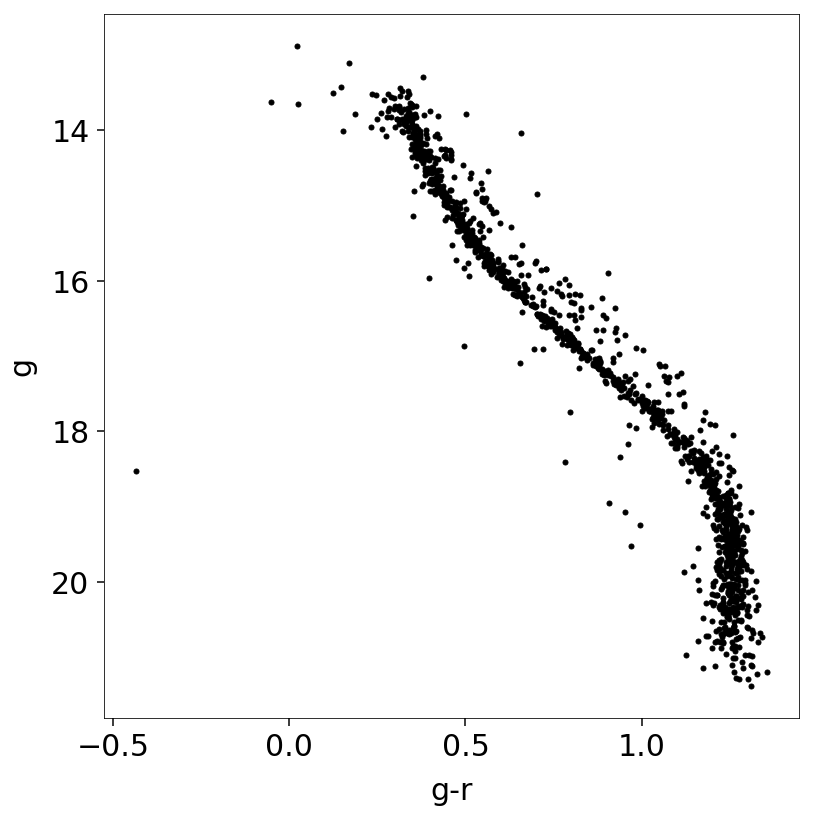

In [7]:
# plot observed CMD

# g-r vs g
ps_g, ps_r = -2.5 * np.log10(phot[:, bandmask_bs][:, [0, 1]]).T

# plot CMDs
plt.figure(figsize=(12, 12))
plt.plot(ps_g - ps_r, ps_g, 
         marker='o', markersize=5,
         color='black', linestyle='none')
plt.xlabel('g-r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.tight_layout()

# Models

In [8]:
# import Bayestar models
version_bs = 'v1'
filepath = '../data/grid_bayestar_' + version_bs + '.h5'
models_bs, labels_bs, lmask_bs = brutus.load_models(filepath, filters=filters)
Nmodels_bs, Nbands_bs, Ncoef_bs = models_bs.shape

Reading filter 2MASS_Ks           


In [9]:
# import MIST models
version_mist = 'v5'
filepath = '../data/grid_' + version_mist + '.h5'
models_mist, labels_mist, lmask_mist = brutus.load_models(filepath, filters=filters)
Nmodels_mist, Nbands_mist, Ncoef_mist = models_mist.shape

Reading filter WISE_W2                  


# No Gaia

Testing accuracy, systematics, etc. on the benchmark cluster.

## Bayestar

Empirical templates calibrated on PS+2MASS. Fitting confined to those two datasets.

In [10]:
# load offsets
offsets_bs = np.loadtxt('../data/offsets_bs_'+version_bs+'.txt', 
                        dtype='str')[:, 1].astype(float)
print(filters_bs)
print(offsets_bs - 1.)

offsets_bs_old = np.array(offsets_bs)

['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
[-0.03055092 -0.04117634 -0.02299008 -0.00212489  0.00897326  0.00838917
  0.01372486  0.00212489]


In [11]:
# load in fitter
from brutus.fitting import BruteForce
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs)

# fit Bayestar models to data
t1 = time.time()
BF_bs.fit(phot[:, bandmask_bs], err[:, bandmask_bs], 
          mask[:, bandmask_bs], info,
          filename+'_bayestar_'+version_bs,
          phot_offsets=offsets_bs_old,
          data_coords=coords, apply_agewt=False)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobj)

Fitting object 1578/1578


Avg time per object: 0.9797965918203724


In [12]:
# load results
f = h5py.File(filename+'_bayestar_'+version_bs+'.h5')
idxs_bs = f['idxs'][:]
chi2_bs = f['best_chi2'][:]
nbands_bs = f['Nbands'][:]
dists_bs = f['dists'][:]
reds_bs = f['reds'][:]

# check number of good fits
good_bs = stats.chi2.sf(chi2_bs, nbands_bs - 2) > 1e-5
Ngood_bs = sum(good_bs)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_bs, Nobj, 
                                         100.*Ngood_bs/Nobj))

Good fits: 1553/1578 [98.41571609632446%]


Best-fit chi2: 1.4252454


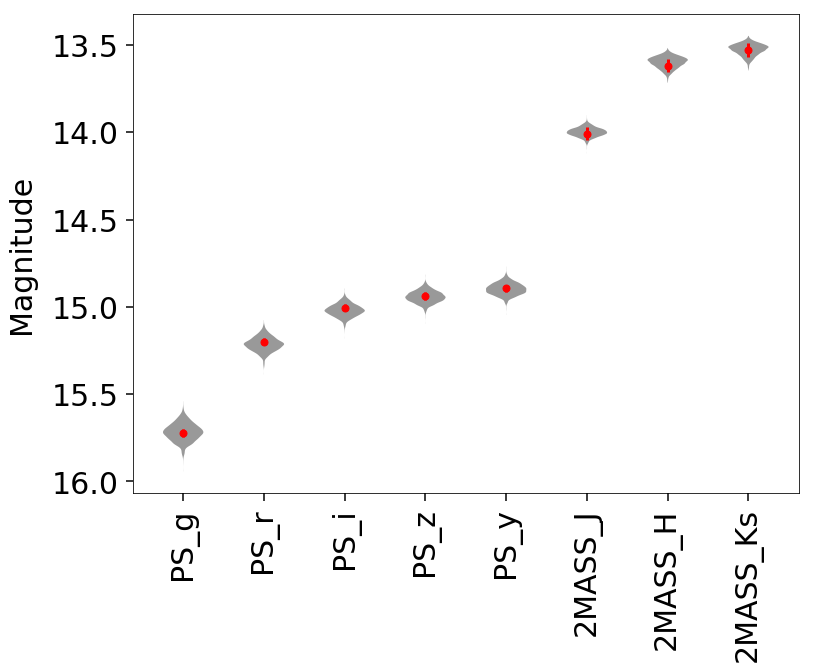

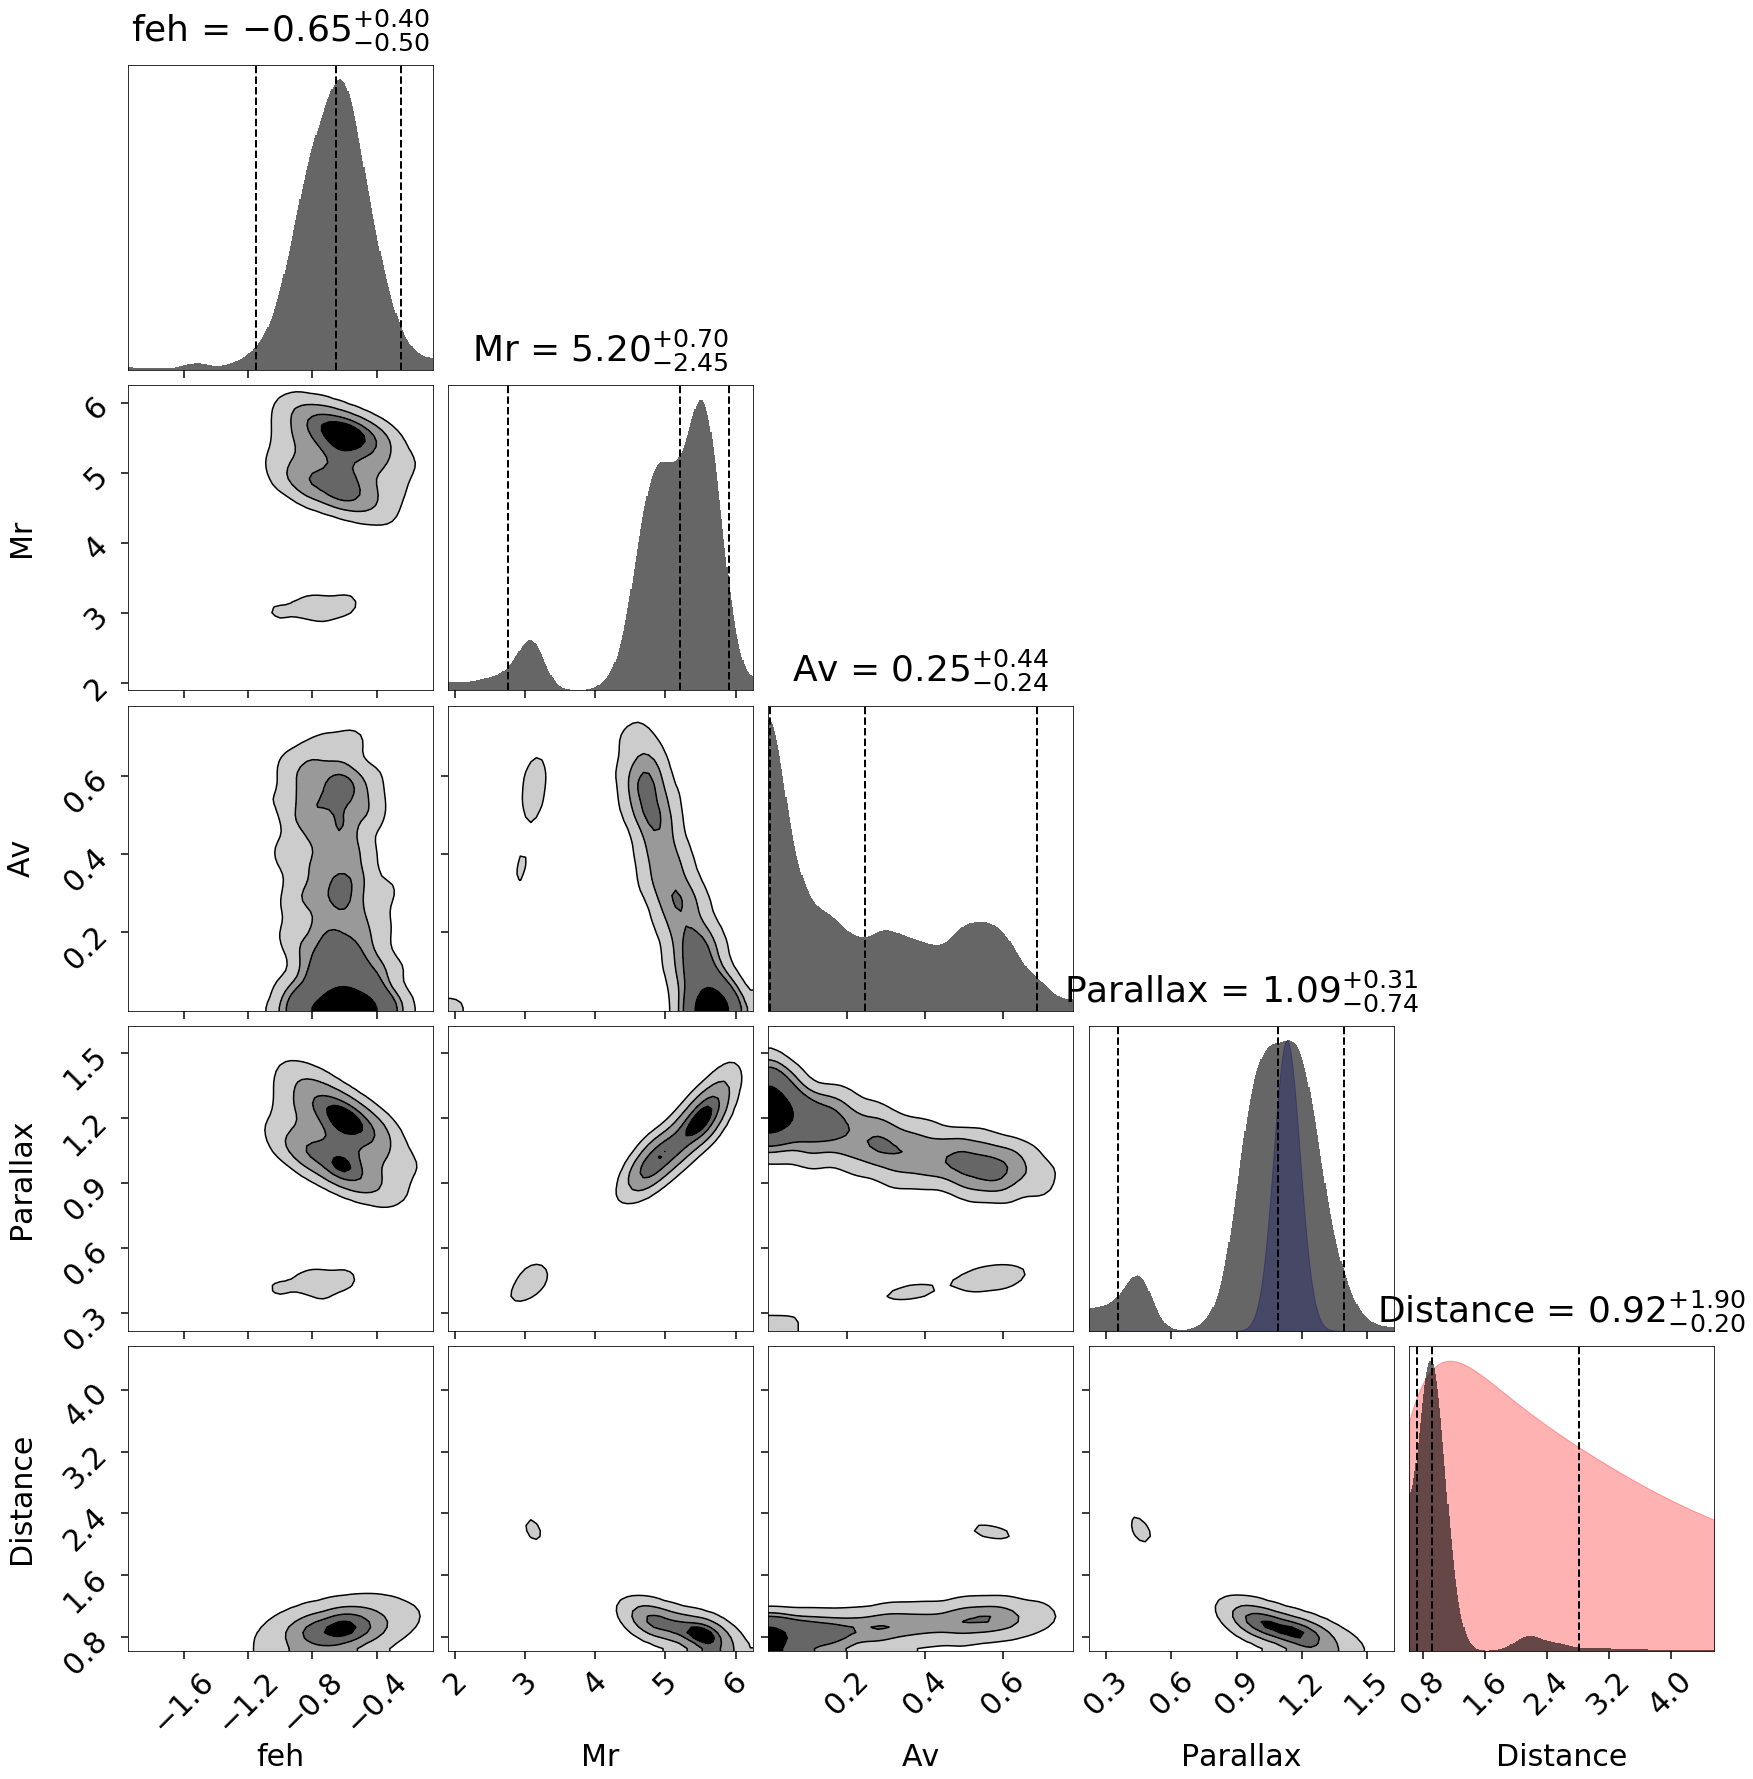

In [154]:
# plot snapshot of results for specific object
from brutus import plotting as bplot
from brutus import fitting

i = 0  # index of object

# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_bs, idxs_bs[i], 
                                            reds_bs[i], dists_bs[i], 
                                            data=phot[i, bandmask_bs], 
                                            data_err=err[i, bandmask_bs],
                                            data_mask=mask[i, bandmask_bs], 
                                            offset=offsets_bs_old,
                                            labels=filters_bs,
                                            vcolor='black')

# cornerplot
print('Best-fit chi2:', chi2_bs[i])
fig, axes = bplot.cornerplot(idxs_bs[i], (dists_bs[i], reds_bs[i]),
                             labels_bs, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

In [14]:
# compute new photometric offsets
from brutus.utils import photometric_offsets
offsets_bs, noff_bs = photometric_offsets(phot[:, bandmask_bs], 
                                          err[:, bandmask_bs], 
                                          mask[:, bandmask_bs], 
                                          models_bs, idxs_bs, reds_bs, dists_bs,
                                          sel=good_bs)
print(filters_bs)
print(offsets_bs - 1.)
print(offsets_bs - offsets_bs_old)

# save to file
#np.savetxt('../data/offsets_bs_'+version_bs+'.txt', np.c_[filters_bs, offsets_bs], fmt='%s')

['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
[-0.03776997 -0.04582106 -0.02589481 -0.00410681  0.00795889  0.00845773
  0.01518455  0.00410681]
[-7.21904468e-03 -4.64472204e-03 -2.90472697e-03 -1.98191593e-03
 -1.01437330e-03  6.85640618e-05  1.45969340e-03  1.98191593e-03]


## MIST

In [22]:
# load offsets
offsets_mist = np.loadtxt('../data/offsets_mist_'+version_mist+'.txt', 
                          dtype='str')[:, 1].astype(float)
print(filters)
print(offsets_mist - 1.)

offsets_mist_old = np.array(offsets_mist)

['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
[ 0.03045118  0.0223192   0.00489312  0.15642314 -0.02120451 -0.03695383
 -0.03563686 -0.02262873 -0.01953486 -0.05936733 -0.03633178 -0.01700446
 -0.00489312  0.02185487  0.06678301  0.05157968  0.05438507  0.08916129]


In [23]:
# load in fitter
from brutus.fitting import BruteForce
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist)

# fit MIST models to data
t1 = time.time()
BF_mist.fit(phot, err, mask, info, 
            filename+'_mist_'+version_mist,
            phot_offsets=offsets_mist_old,
            data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobj)

Fitting object 1578/1578


Avg time per object: 3.8542894617535164


In [24]:
# load MIST results
f = h5py.File(filename+'_mist_'+version_mist+'.h5')
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
nbands_mist = f['Nbands'][:]
dists_mist = f['dists'][:]
reds_mist = f['reds'][:]

# check number of good fits
good_mist = stats.chi2.sf(chi2_mist, nbands_mist - 2) > 1e-5
Ngood_mist = sum(good_mist)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_mist, Nobj, 
                                         100.*Ngood_mist/Nobj))

# check number of high(er)-mass fits
hmass_mist = np.percentile(labels_mist['mini'][idxs_mist], 
                           2.5, axis=1) > 0.34  # 97.5% of P(M) > 0.34
hmass_mist *= np.percentile(labels_mist['mini'][idxs_mist], 
                            97.5, axis=1) < 9. # 97.5% of P(M) < 9.
Nhmass_mist = sum(hmass_mist)
print('High-mass fits: {0}/{1} [{2}%]'.format(Nhmass_mist, Nobj, 
                                              100.*Nhmass_mist/Nobj))

# combined selection criteria
sel_mist = good_mist & hmass_mist
Nsel_mist = sum(sel_mist)
print('Selected fits: {0}/{1} [{2}%]'.format(Nsel_mist, Nobj, 
                                             100.*Nsel_mist/Nobj))

Good fits: 1240/1578 [78.58048162230672%]
High-mass fits: 1005/1578 [63.68821292775665%]
Selected fits: 785/1578 [49.746514575411915%]


Best-fit chi2: 2.7363043


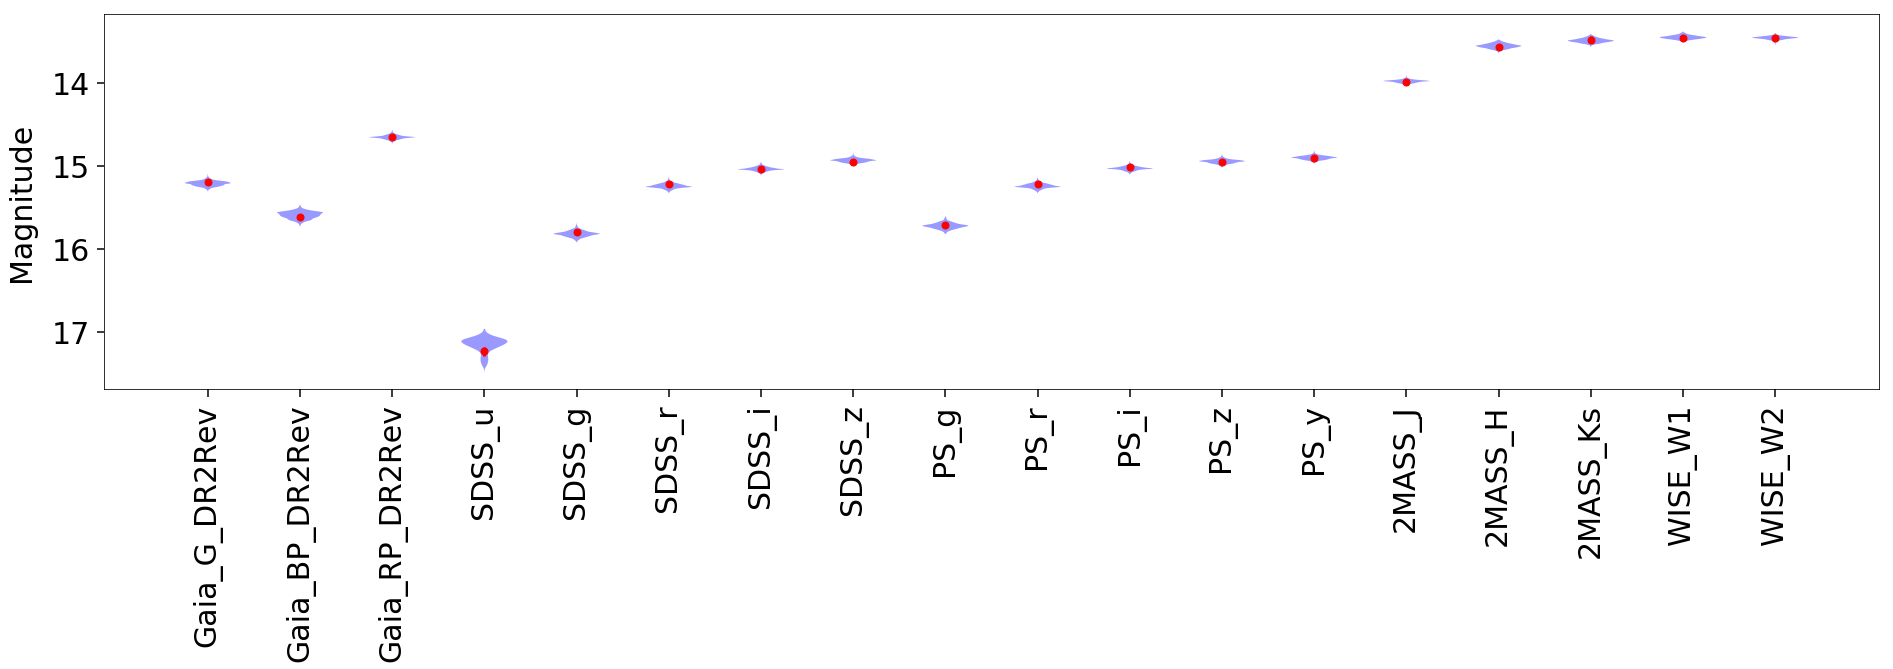

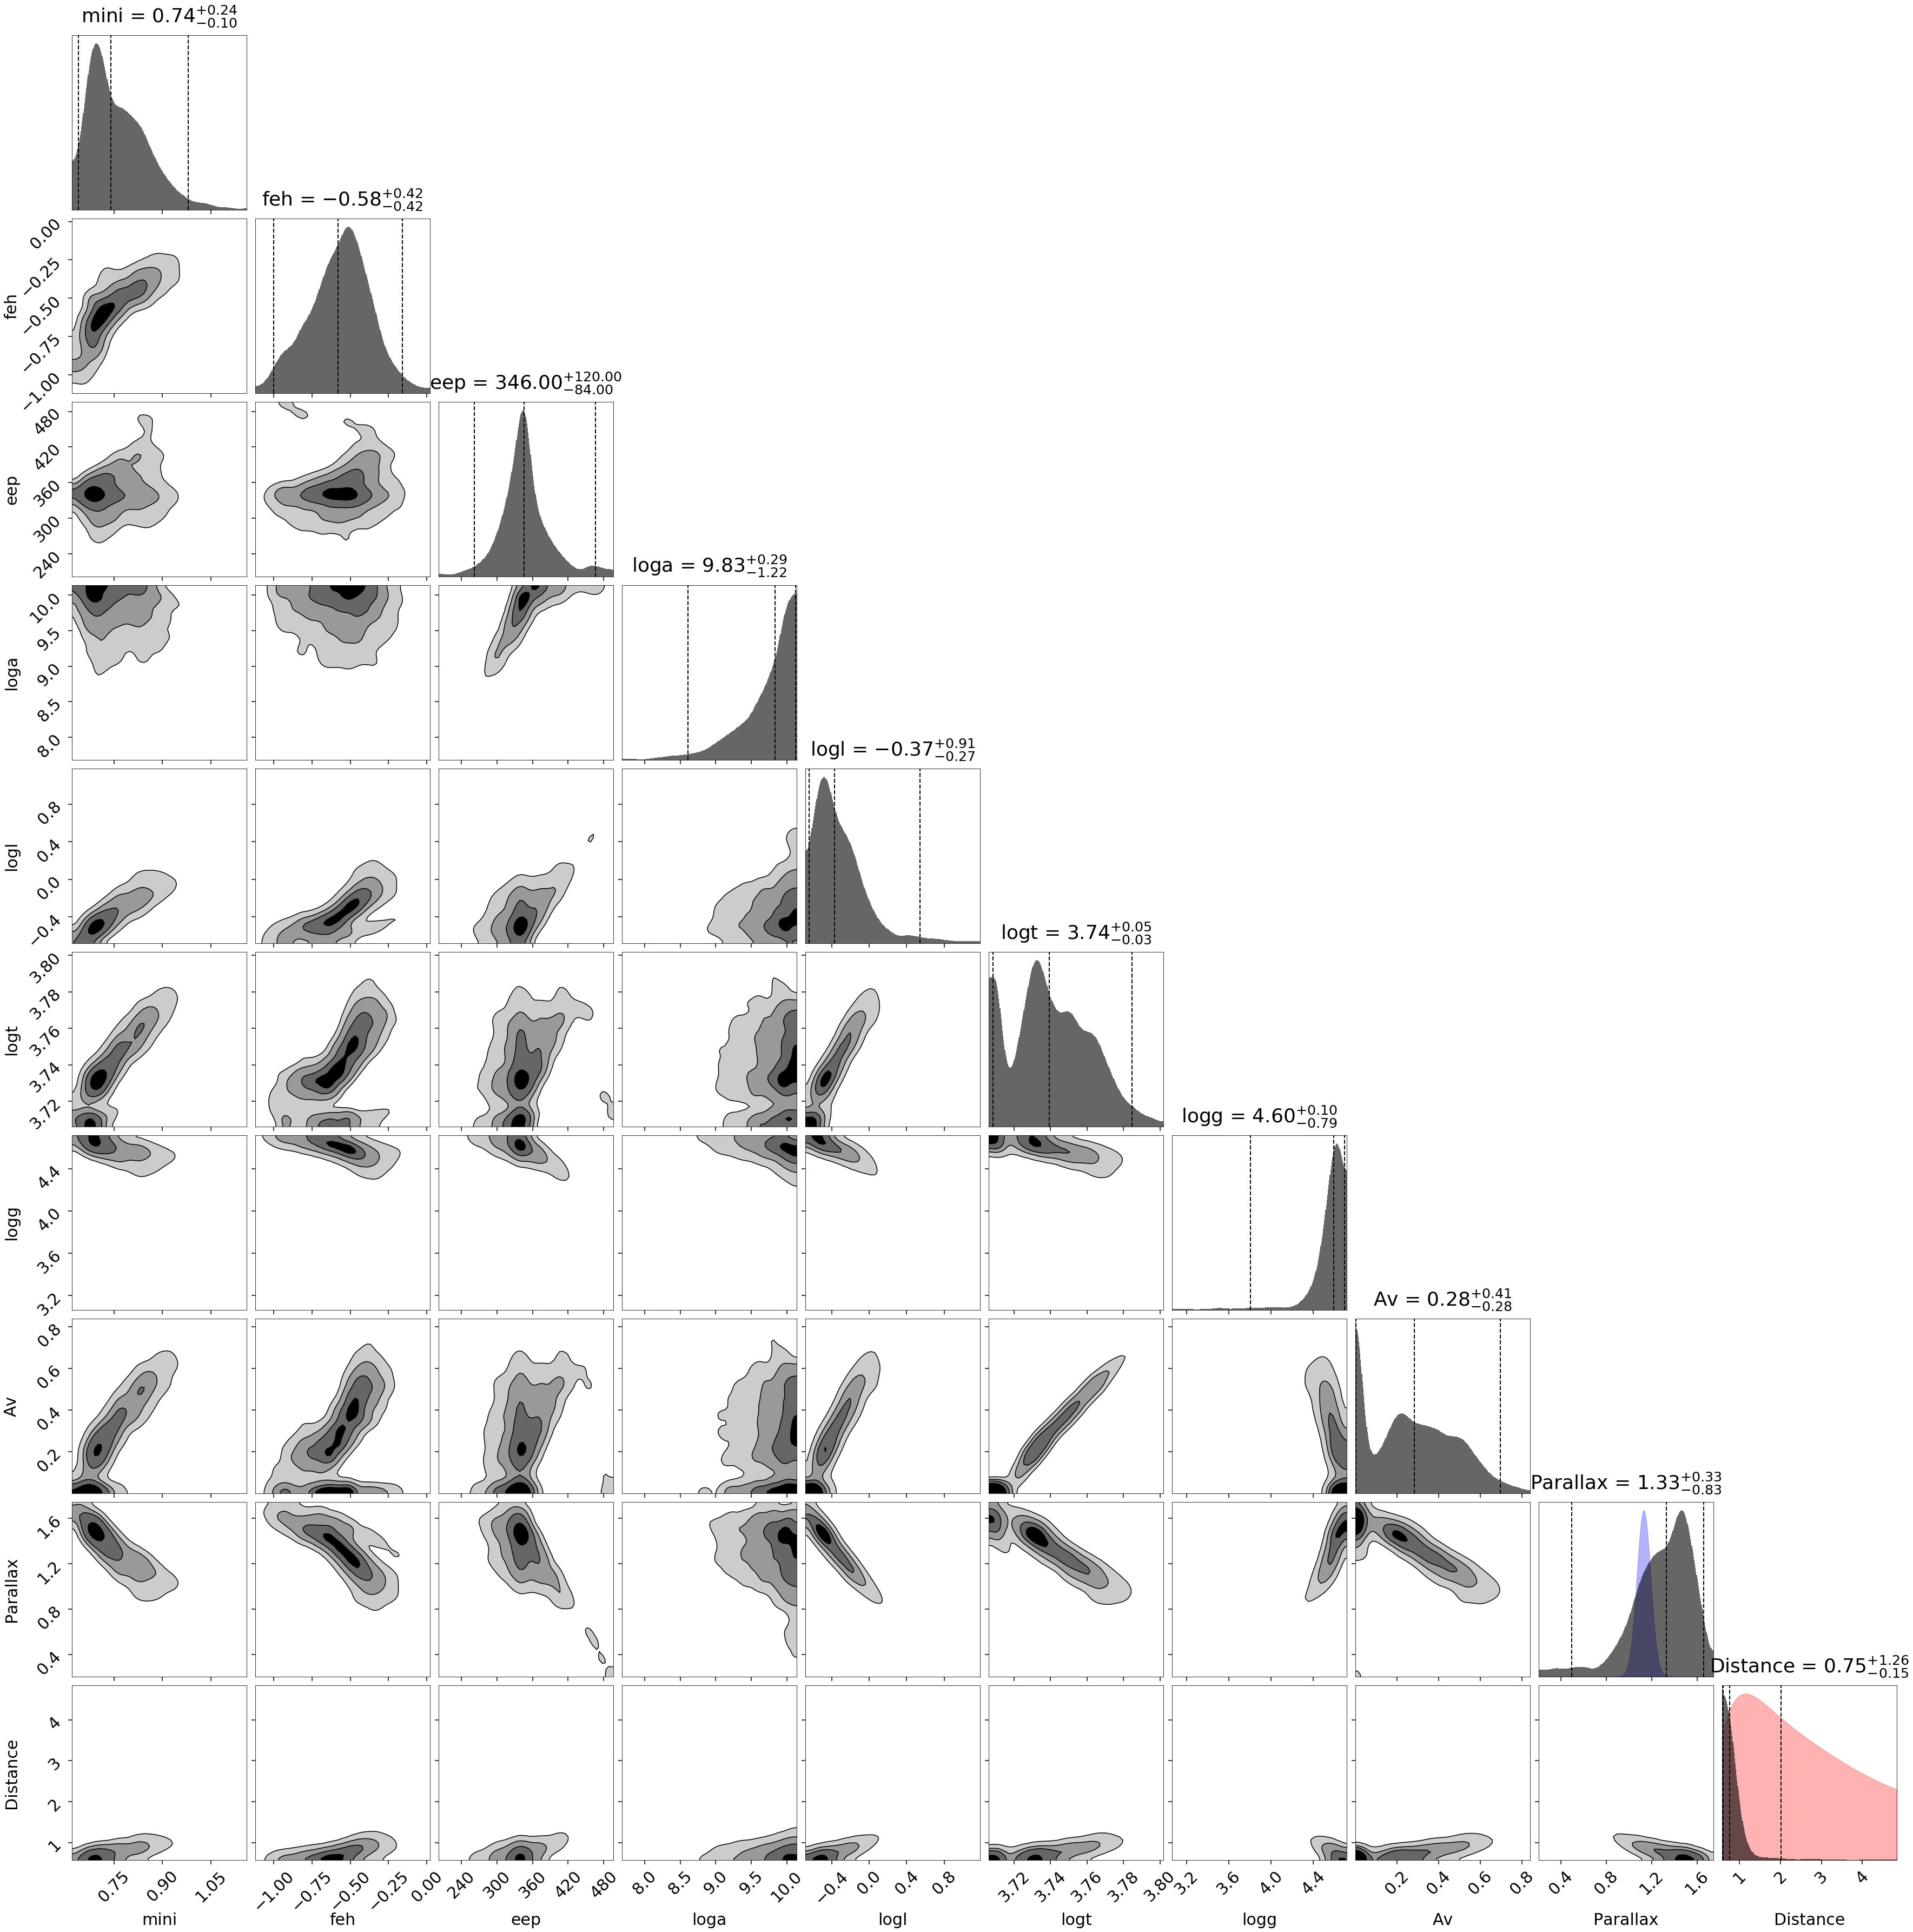

In [155]:
# plot snapshot of results for specific object
from brutus import plotting as bplot
from brutus import fitting

i = 0  # index of target object

# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_mist, idxs_mist[i], 
                                            reds_mist[i], dists_mist[i], 
                                            data=phot[i], data_err=err[i],
                                            data_mask=mask[i], 
                                            offset=offsets_mist_old,
                                            labels=filters,
                                            vcolor='blue')

# cornerplot
print('Best-fit chi2:', chi2_mist[i])
fig, axes = bplot.cornerplot(idxs_mist[i], (dists_mist[i], reds_mist[i]),
                             labels_mist, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

In [26]:
# compute photometric ratios
from brutus.utils import photometric_offsets
offsets_mist, noff_mist = photometric_offsets(phot, err, mask, 
                                              models_mist, idxs_mist,
                                              reds_mist, dists_mist,
                                              sel=sel_mist)
print(filters)
print(offsets_mist - 1.)
print(offsets_mist - offsets_mist_old)

# save to file
#np.savetxt('../data/offsets_mist_'+version_mist+'.txt', np.c_[filters, offsets_mist], fmt='%s')

['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
[ 0.02895514  0.01884969  0.00324197  0.15949456 -0.0270989  -0.042809
 -0.03842088 -0.02168652 -0.0248004  -0.06556677 -0.03946369 -0.01659557
 -0.00324197  0.0243193   0.0674044   0.05288752  0.05787316  0.09530737]
[-0.00149604 -0.00346951 -0.00165116  0.00307141 -0.00589439 -0.00585517
 -0.00278403  0.00094221 -0.00526554 -0.00619944 -0.00313191  0.00040889
  0.00165116  0.00246443  0.00062139  0.00130784  0.00348809  0.00614608]


## CMDs

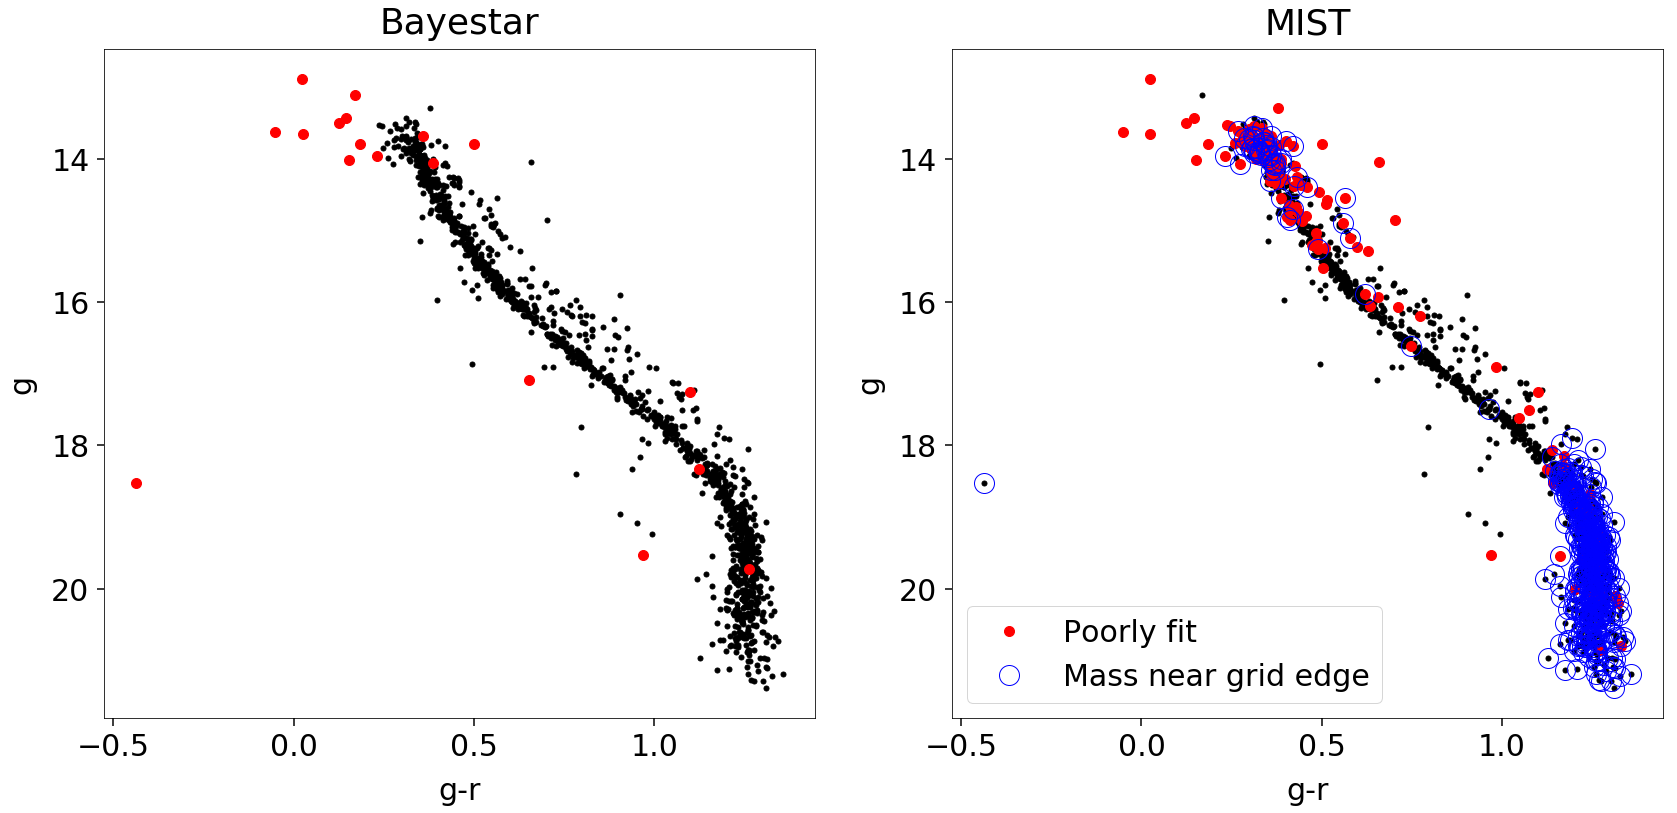

In [101]:
# plot observed CMDs and selection

# g-r vs g
ps_g, ps_r = -2.5 * np.log10(phot[:, bandmask_bs][:, :2]).T

# plot CMDs
plt.figure(figsize=(24, 12))
# Bayestar
plt.subplot(1, 2, 1)
plt.plot(ps_g - ps_r, ps_g, 
         marker='o', markersize=5,
         color='black', linestyle='none')
plt.plot((ps_g - ps_r)[~good_bs], ps_g[~good_bs], 
         marker='o', markersize=10, 
         color='red', linestyle='none')
plt.xlabel('g-r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('Bayestar')
plt.tight_layout()
# MIST
plt.subplot(1, 2, 2)
plt.plot(ps_g - ps_r, ps_g, 
         marker='o', markersize=5,
         color='black', linestyle='none')
plt.plot((ps_g - ps_r)[~good_mist], ps_g[~good_mist], 
         marker='o', markersize=10, 
         color='red', linestyle='none',
         label='Poorly fit')
plt.plot((ps_g - ps_r)[~hmass_mist], ps_g[~hmass_mist], 
         marker='o', markersize=20, 
         markerfacecolor='none',
         color='blue', linestyle='none',
         label='Mass near grid edge')
plt.xlabel('g-r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('MIST')
plt.legend()
plt.tight_layout()

## Stacked PDFs

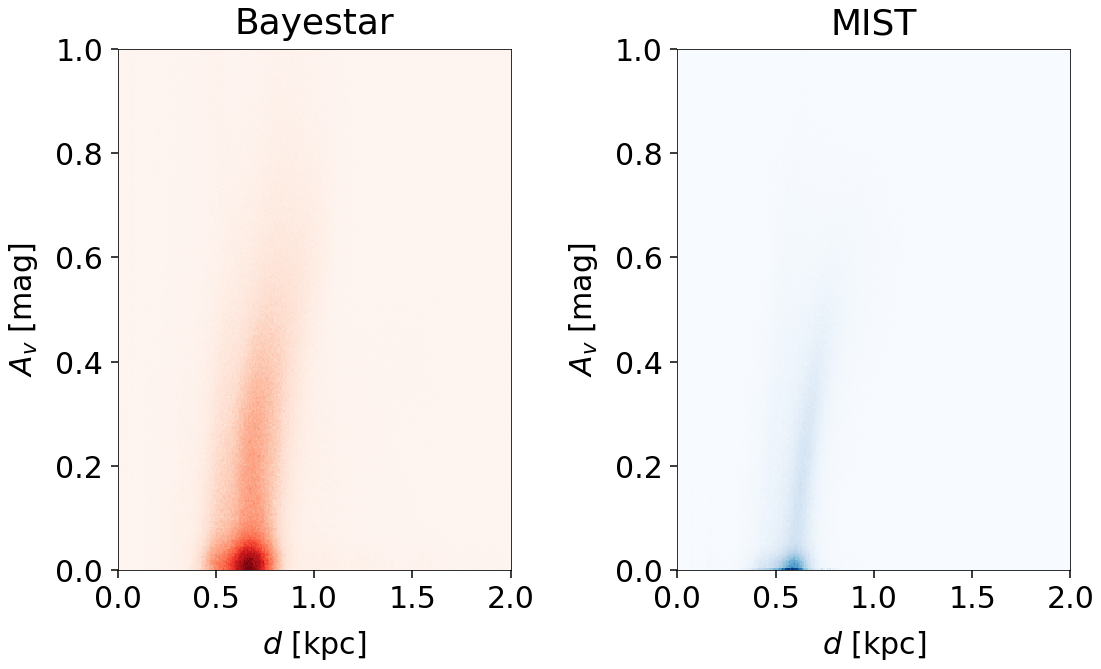

In [151]:
# plot stacked reddening vs distance posteriors
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
bplot.dist_vs_red((dists_bs[good_bs].flatten(), 
                   reds_bs[good_bs].flatten()),
                  dist_type='distance',
                  span=[(0., 1.), (0., 2.)],
                  smooth=0.,
                  cmap='Reds')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 2, 2)
bplot.dist_vs_red((dists_mist[sel_mist].flatten(),
                   reds_mist[sel_mist].flatten()), 
                  dist_type='distance',
                  span=[(0., 1.), (0., 2.)],
                  smooth=0.,
                  cmap='Blues')
plt.title('MIST')
plt.tight_layout()

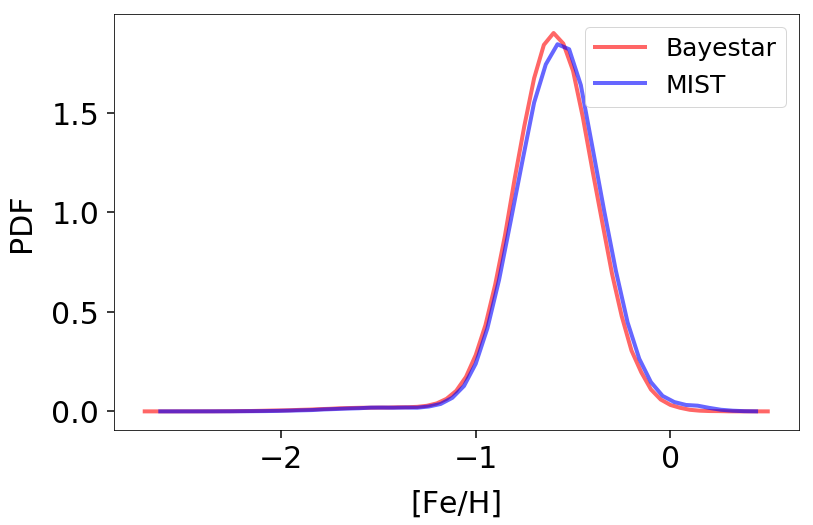

In [146]:
# plot metallicity distribution
plt.figure(figsize=(12, 8))
feh_bs, feh_bs_counts = np.unique(labels_bs['feh'][idxs_bs[good_bs]], 
                                  return_counts=True)
feh_mist, feh_mist_counts = np.unique(labels_mist['feh'][idxs_mist[sel_mist]], 
                                  return_counts=True)
plt.plot(feh_bs, feh_bs_counts / np.trapz(feh_bs_counts, feh_bs),
         lw=4, color='red', alpha=0.6, label='Bayestar')
plt.plot(feh_mist, feh_mist_counts / np.trapz(feh_mist_counts, feh_mist),
         lw=4, color='blue', alpha=0.6, label='MIST')
plt.xlabel('[Fe/H]')
plt.ylabel('PDF')
plt.legend(fontsize='small')
plt.tight_layout()

# With Gaia

Testing stability, recovered quantities, etc.

## Bayestar

In [136]:
# load offsets
offsets_bs = np.loadtxt('../data/offsets_bs_'+version_bs+'.txt', 
                        dtype='str')[:, 1].astype(float)
print(filters_bs)
print(offsets_bs - 1.)

offsets_bs_old = np.array(offsets_bs)

['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
[-0.03055092 -0.04117634 -0.02299008 -0.00212489  0.00897326  0.00838917
  0.01372486  0.00212489]


In [137]:
# load in fitter
from brutus.fitting import BruteForce
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs)

# fit Bayestar models to data
t1 = time.time()
BF_bs.fit(phot[:, bandmask_bs], err[:, bandmask_bs], 
          mask[:, bandmask_bs], info, 
          filename+'_bayestar_'+version_bs+'_gaia',
          phot_offsets=offsets_bs,
          parallax=parallax, parallax_err=parallax_err,
          data_coords=coords, apply_agewt=False)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobj)

Fitting object 1578/1578


Avg time per object: 0.4061217234010781


In [138]:
# load results
f = h5py.File(filename+'_bayestar_'+version_bs+'_gaia'+'.h5')
idxs_bs_gaia = f['idxs'][:]
chi2_bs_gaia = f['best_chi2'][:]
nbands_bs_gaia = f['Nbands'][:]
dists_bs_gaia = f['dists'][:]
reds_bs_gaia = f['reds'][:]

# check number of good fits
good_bs_gaia = stats.chi2.sf(chi2_bs_gaia, nbands_bs_gaia - 2) > 1e-5
Ngood_bs_gaia = sum(good_bs_gaia)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_bs_gaia, Nobj, 
                                         100.*Ngood_bs_gaia/Nobj))

Good fits: 1543/1578 [97.78200253485424%]


Best-fit chi2: 1.4300241


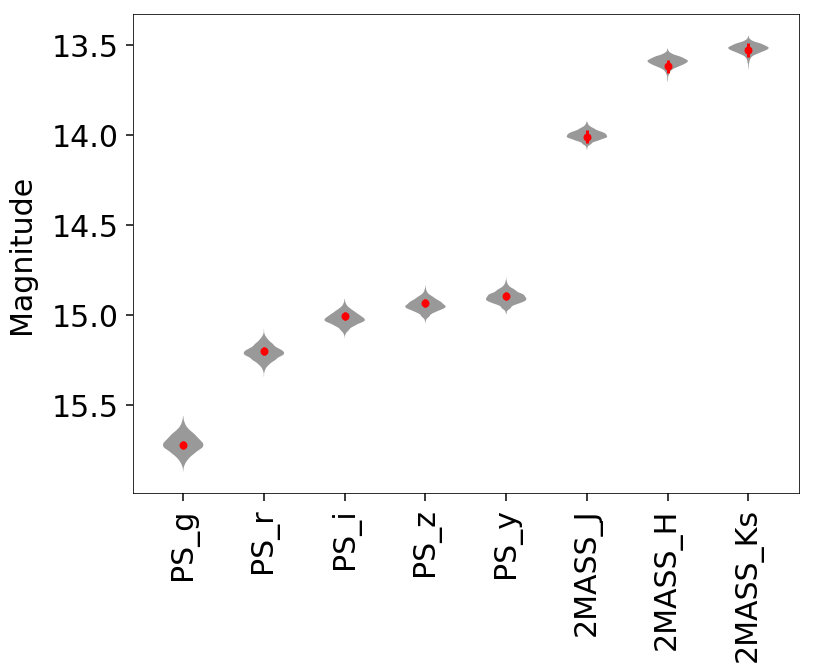

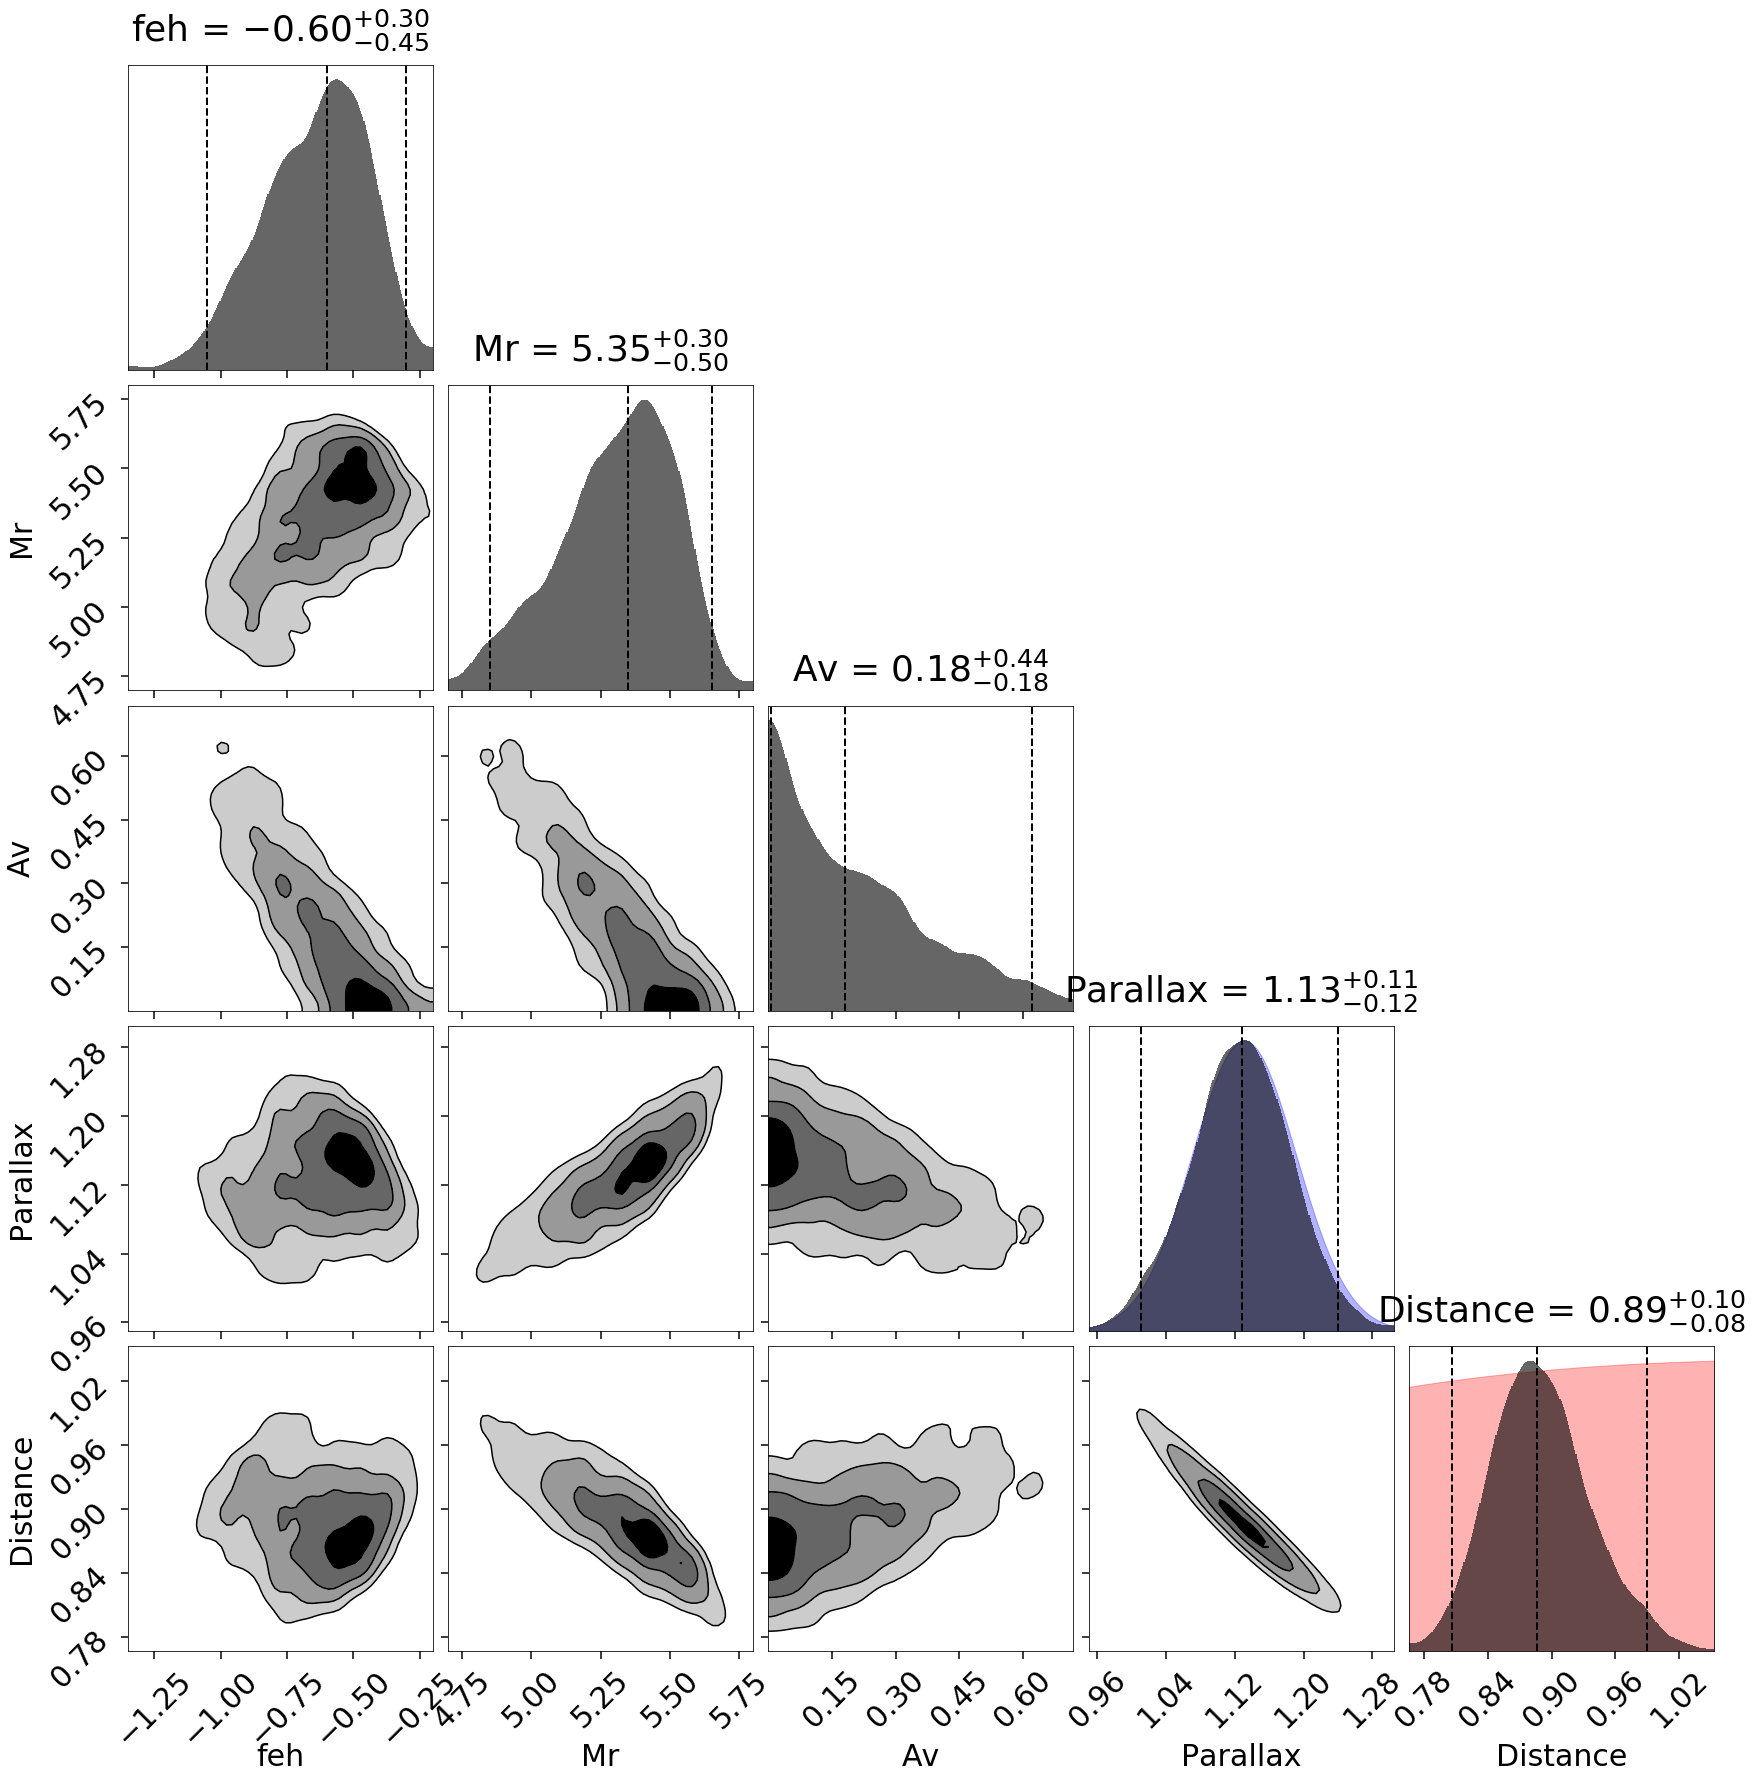

In [156]:
# plot snapshot of results for specific object
from brutus import plotting as bplot
from brutus import fitting

i = 0  # index of object

# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_bs, idxs_bs_gaia[i], 
                                            reds_bs_gaia[i], dists_bs_gaia[i], 
                                            data=phot[i, bandmask_bs], 
                                            data_err=err[i, bandmask_bs],
                                            data_mask=mask[i, bandmask_bs], 
                                            offset=offsets_bs_old,
                                            labels=filters_bs,
                                            vcolor='black')

# cornerplot
print('Best-fit chi2:', chi2_bs_gaia[i])
fig, axes = bplot.cornerplot(idxs_bs_gaia[i], (dists_bs_gaia[i], reds_bs_gaia[i]),
                             labels_bs, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

In [140]:
# compute new photometric offsets
from brutus.utils import photometric_offsets
offsets_bs, noff_bs = photometric_offsets(phot[:, bandmask_bs], 
                                          err[:, bandmask_bs], 
                                          mask[:, bandmask_bs], 
                                          models_bs, idxs_bs_gaia,
                                          reds_bs_gaia, dists_bs_gaia,
                                          sel=good_bs_gaia)
print(filters_bs)
print(offsets_bs - 1.)
print(offsets_bs - offsets_bs_old)

# save to file
#np.savetxt('../data/offsets_bs_'+version_bs+'.txt', np.c_[filters_bs, offsets_bs], fmt='%s')

['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
[-0.03334088 -0.04461186 -0.02663613 -0.00076573  0.01260711  0.01337699
  0.01252185  0.00076573]
[-0.00278996 -0.00343552 -0.00364605  0.00135916  0.00363384  0.00498782
 -0.00120301 -0.00135916]


## MIST

In [141]:
# load offsets
offsets_mist = np.loadtxt('../data/offsets_mist_'+version_mist+'.txt', 
                          dtype='str')[:, 1].astype(float)
print(filters)
print(offsets_mist - 1.)

offsets_mist_old = np.array(offsets_mist)

['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
[ 0.03045118  0.0223192   0.00489312  0.15642314 -0.02120451 -0.03695383
 -0.03563686 -0.02262873 -0.01953486 -0.05936733 -0.03633178 -0.01700446
 -0.00489312  0.02185487  0.06678301  0.05157968  0.05438507  0.08916129]


In [142]:
# load in fitter
from brutus.fitting import BruteForce
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist)

# fit MIST models to data
t1 = time.time()
BF_mist.fit(phot, err, mask, info, 
            filename+'_mist_'+version_mist+'_gaia',
            phot_offsets=offsets_mist_old,
            parallax=parallax, parallax_err=parallax_err,
            data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobj)

Fitting object 1578/1578


Avg time per object: 3.186856351273444


In [143]:
# load MIST results
f = h5py.File(filename+'_mist_'+version_mist+'_gaia'+'.h5')
idxs_mist_gaia = f['idxs'][:]
chi2_mist_gaia = f['best_chi2'][:]
nbands_mist_gaia = f['Nbands'][:]
dists_mist_gaia = f['dists'][:]
reds_mist_gaia = f['reds'][:]

# check number of good fits
good_mist_gaia = stats.chi2.sf(chi2_mist_gaia, nbands_mist_gaia - 2) > 1e-5
Ngood_mist_gaia = sum(good_mist_gaia)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_mist_gaia, Nobj, 
                                         100.*Ngood_mist_gaia/Nobj))

# check number of high(er)-mass fits
hmass_mist_gaia = np.percentile(labels_mist['mini'][idxs_mist_gaia], 
                                2.5, axis=1) > 0.34  # 97.5% of P(M) > 0.34
hmass_mist_gaia *= np.percentile(labels_mist['mini'][idxs_mist_gaia], 
                                 97.5, axis=1) < 9.  # 97.5% of P(M) < 9
Nhmass_mist_gaia = sum(hmass_mist_gaia)
print('High-mass fits: {0}/{1} [{2}%]'.format(Nhmass_mist_gaia, Nobj, 
                                              100.*Nhmass_mist_gaia/Nobj))

# combined selection criteria
sel_mist_gaia = good_mist_gaia & hmass_mist_gaia
Nsel_mist_gaia = sum(sel_mist_gaia)
print('Selected fits: {0}/{1} [{2}%]'.format(Nsel_mist_gaia, Nobj, 
                                             100.*Nsel_mist_gaia/Nobj))

Good fits: 1229/1578 [77.88339670468947%]
High-mass fits: 1360/1578 [86.1850443599493%]
Selected fits: 1073/1578 [67.99746514575412%]


Best-fit chi2: 2.570332


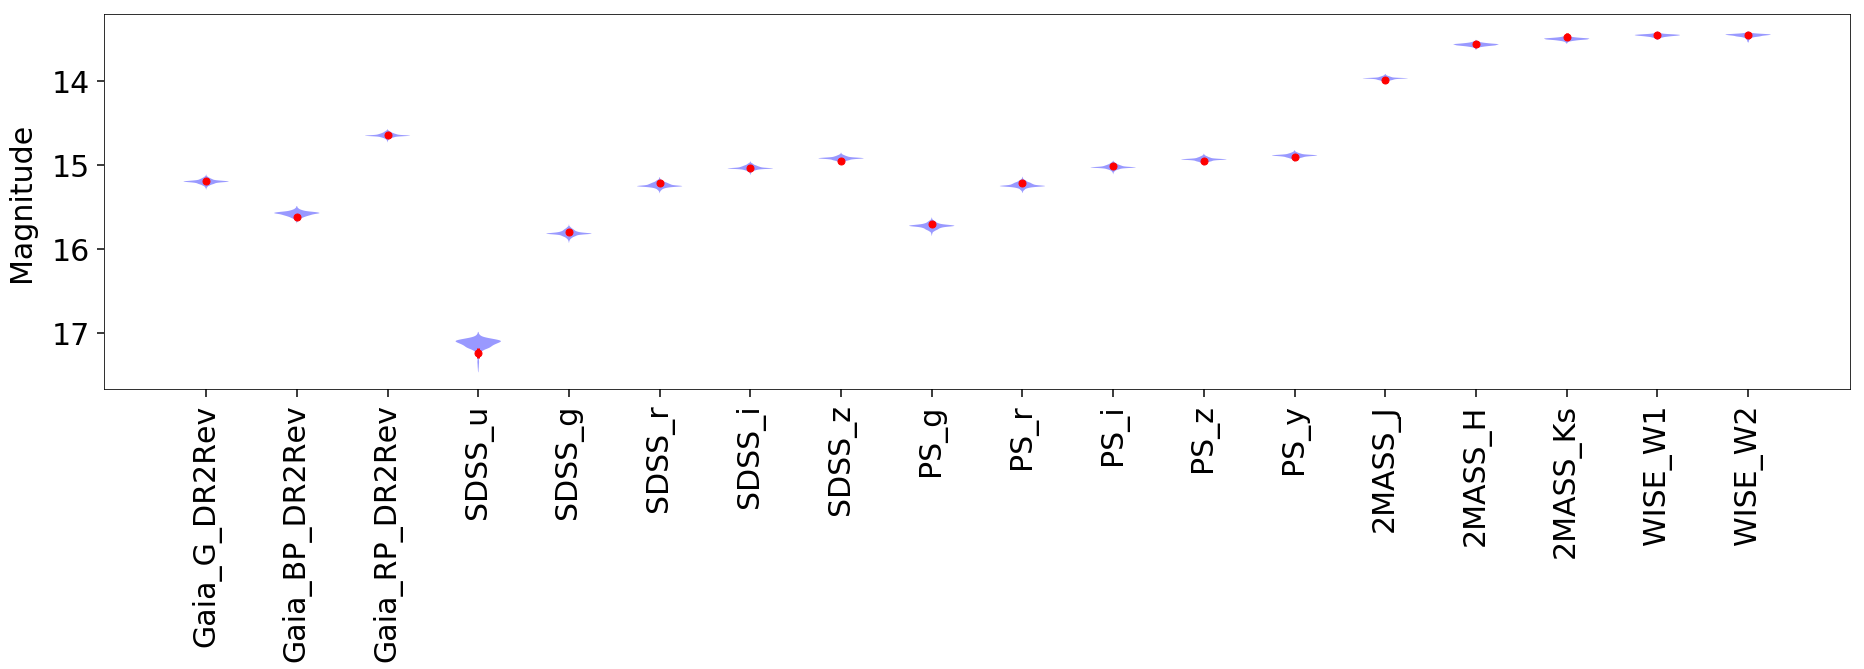

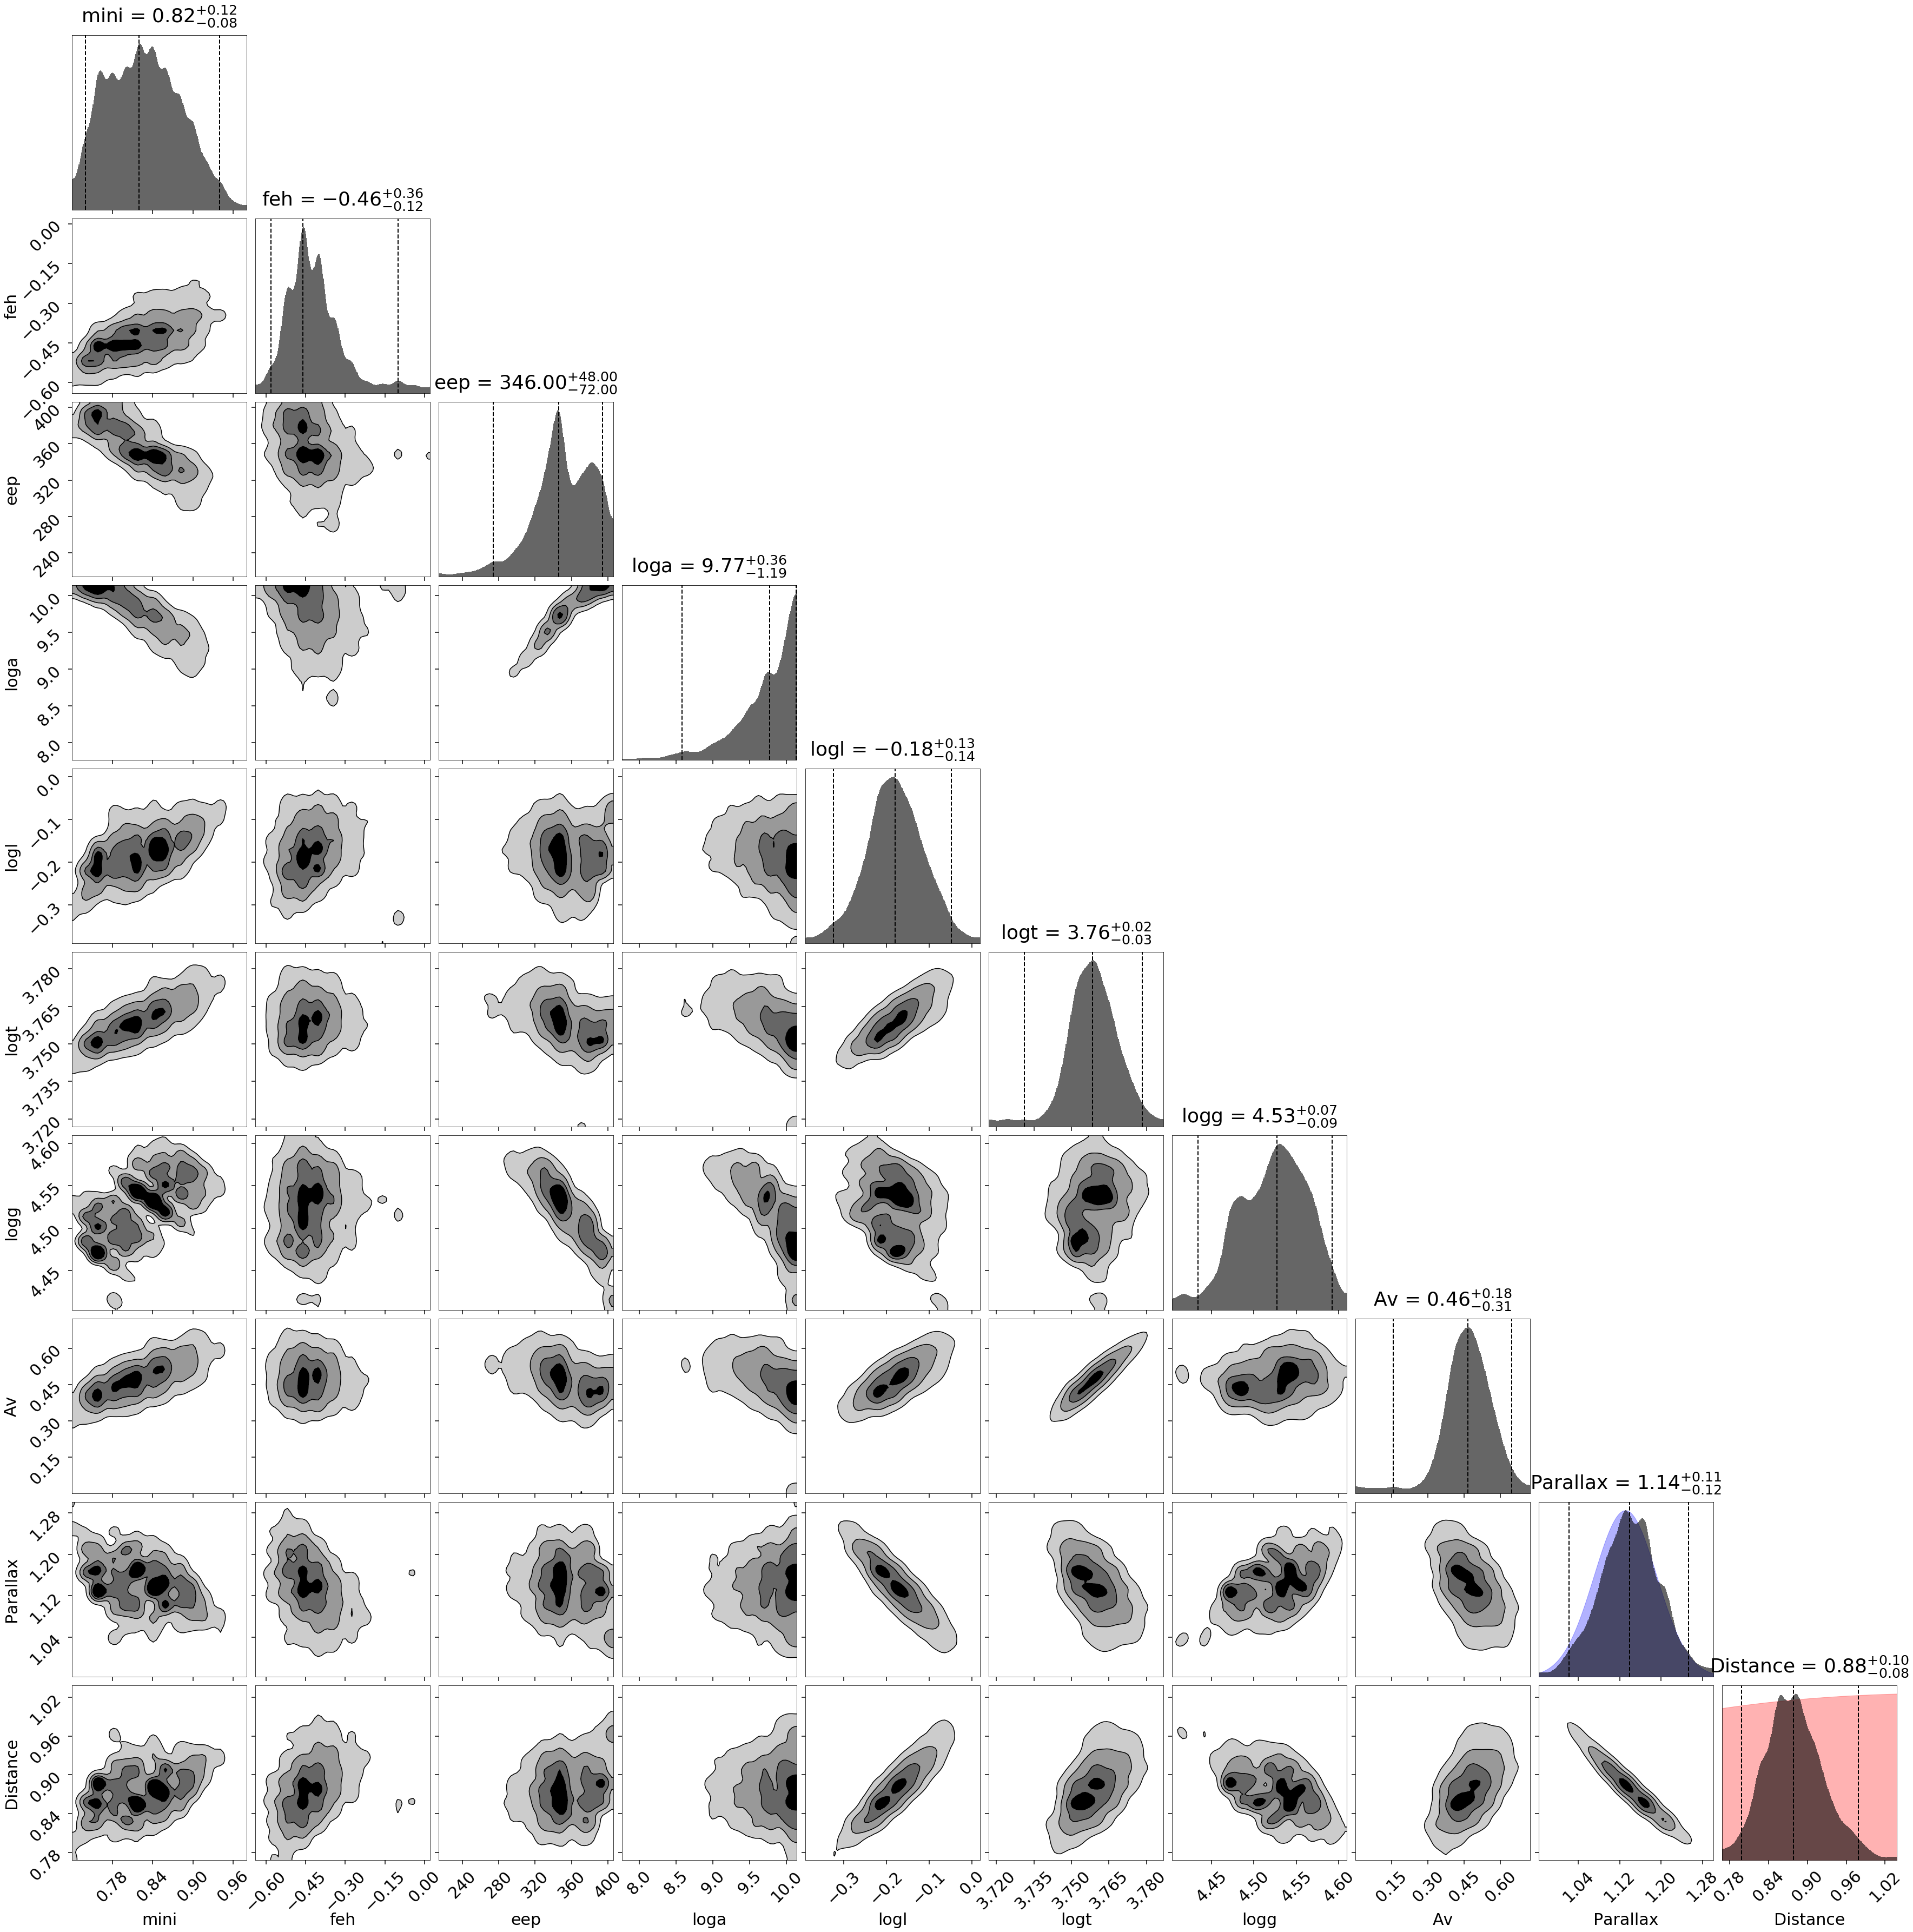

In [157]:
# plot snapshot of results for specific object
from brutus import plotting as bplot
from brutus import fitting

i = 0  # index of target object

fig, ax, parts = bplot.posterior_predictive(models_mist, idxs_mist_gaia[i], 
                                            reds_mist_gaia[i], dists_mist_gaia[i], 
                                            data=phot[i], data_err=err[i],
                                            data_mask=mask[i], 
                                            offset=offsets_mist_old,
                                            labels=filters,
                                            vcolor='blue')

# cornerplot
print('Best-fit chi2:', chi2_mist_gaia[i])
fig, axes = bplot.cornerplot(idxs_mist_gaia[i], (dists_mist_gaia[i], reds_mist_gaia[i]),
                             labels_mist, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

In [145]:
# compute photometric ratios
from brutus.utils import photometric_offsets
offsets_mist, noff_mist = photometric_offsets(phot, err, mask, 
                                              models_mist, idxs_mist_gaia,
                                              reds_mist_gaia, dists_mist_gaia,
                                              sel=sel_mist_gaia)
print(filters)
print(offsets_mist - 1.)
print(offsets_mist - offsets_mist_old)

# save to file
#np.savetxt('../data/offsets_mist_'+version_mist+'.txt', np.c_[filters, offsets_mist], fmt='%s')

['Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_W1', 'WISE_W2']
[ 0.03884709  0.0224159  -0.00151583  0.16724269 -0.0205126  -0.0491344
 -0.04806286 -0.02180152 -0.0278327  -0.07677745 -0.04851429 -0.01811727
  0.00151583  0.03561865  0.05601029  0.04205006  0.05400504  0.08928664]
[ 8.39590737e-03  9.66977725e-05 -6.40895758e-03  1.08195456e-02
  6.91913892e-04 -1.21805723e-02 -1.24260059e-02  8.27214298e-04
 -8.29783675e-03 -1.74101192e-02 -1.21825132e-02 -1.11280858e-03
  6.40895758e-03  1.37637768e-02 -1.07727198e-02 -9.52962167e-03
 -3.80024001e-04  1.25348861e-04]


## CMDs

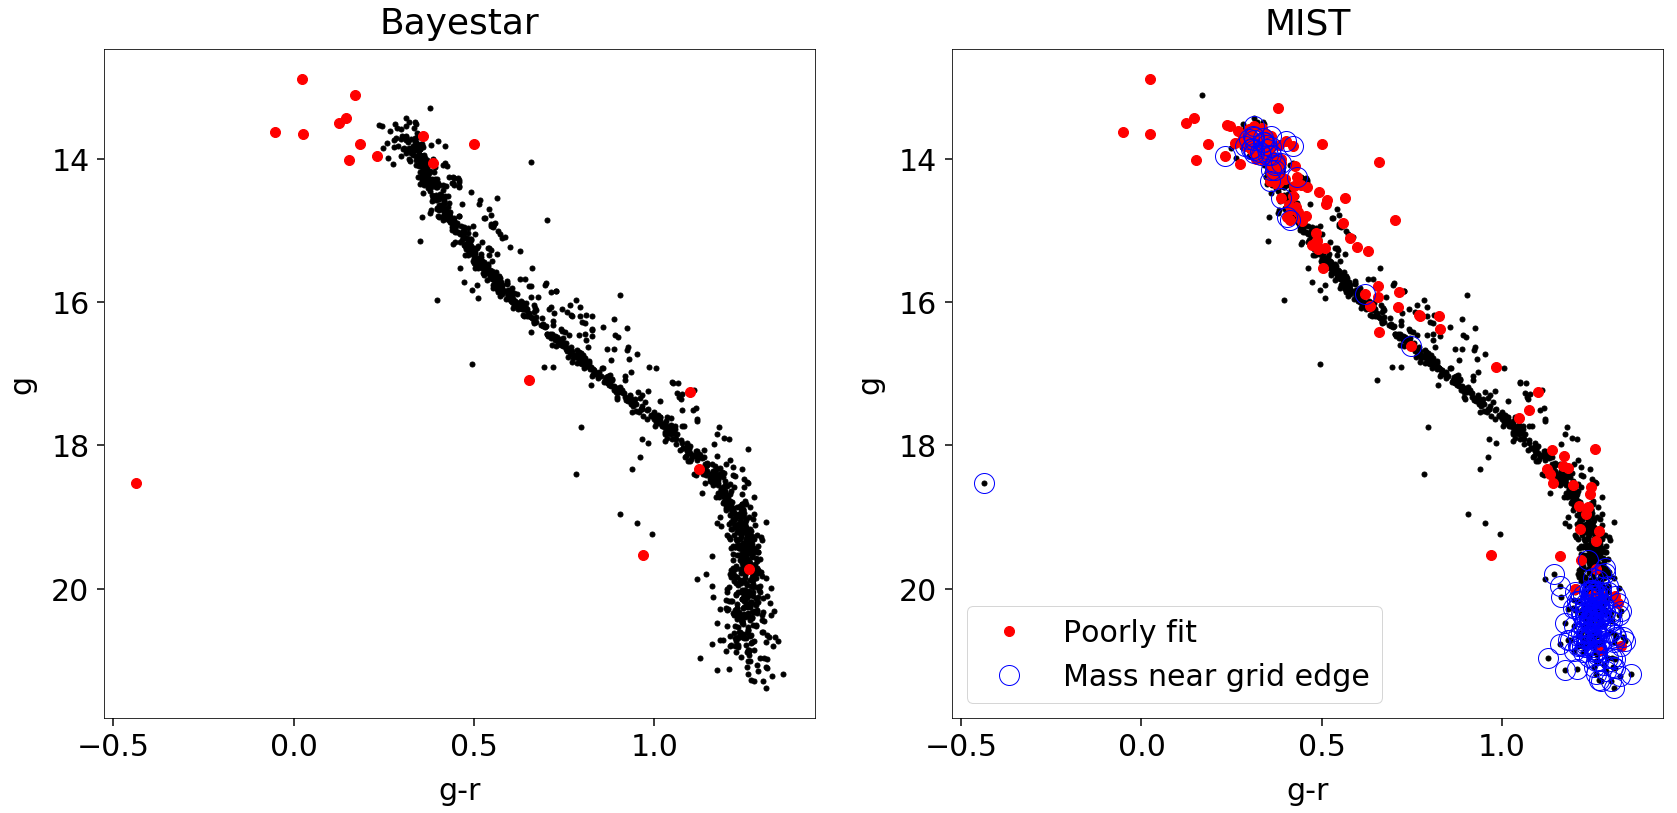

In [147]:
# plot observed CMDs and selection

# g-r vs g
ps_g, ps_r = -2.5 * np.log10(phot[:, bandmask_bs][:, :2]).T

# plot CMDs
plt.figure(figsize=(24, 12))
# Bayestar
plt.subplot(1, 2, 1)
plt.plot(ps_g - ps_r, ps_g, 
         marker='o', markersize=5,
         color='black', linestyle='none')
plt.plot((ps_g - ps_r)[~good_bs_gaia], ps_g[~good_bs_gaia], 
         marker='o', markersize=10, 
         color='red', linestyle='none')
plt.xlabel('g-r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('Bayestar')
plt.tight_layout()
# MIST
plt.subplot(1, 2, 2)
plt.plot(ps_g - ps_r, ps_g, 
         marker='o', markersize=5,
         color='black', linestyle='none')
plt.plot((ps_g - ps_r)[~good_mist_gaia], ps_g[~good_mist_gaia], 
         marker='o', markersize=10, 
         color='red', linestyle='none',
         label='Poorly fit')
plt.plot((ps_g - ps_r)[~hmass_mist_gaia], ps_g[~hmass_mist_gaia], 
         marker='o', markersize=20, 
         markerfacecolor='none',
         color='blue', linestyle='none',
         label='Mass near grid edge')
plt.xlabel('g-r')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.title('MIST')
plt.legend()
plt.tight_layout()

## Stacked PDFs

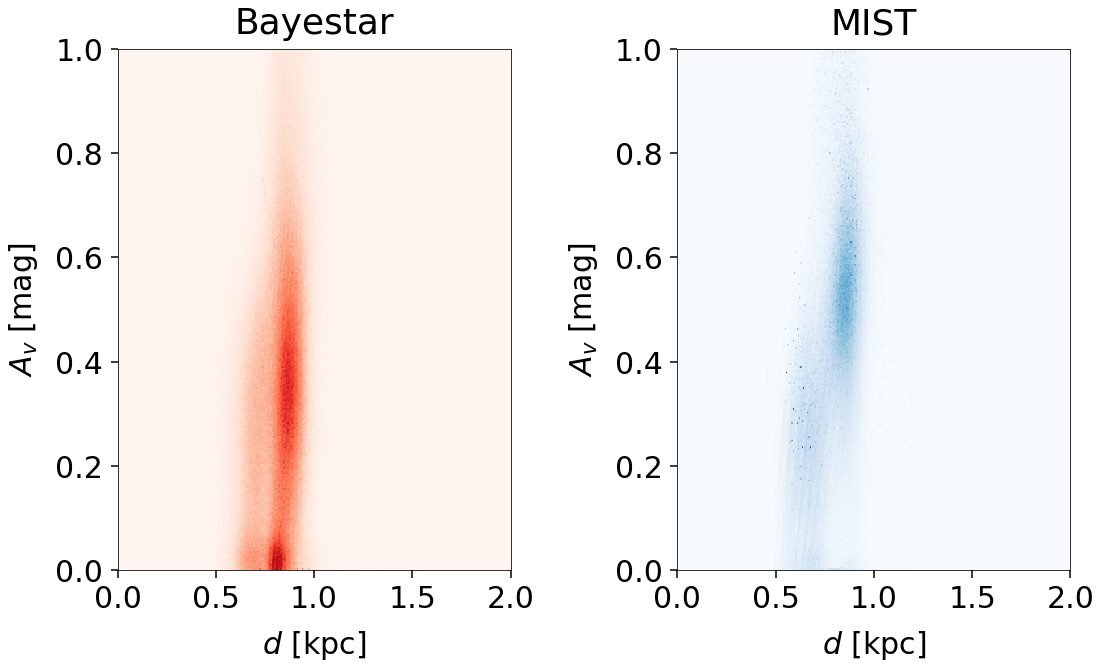

In [152]:
# plot stacked reddening vs distance posteriors
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
bplot.dist_vs_red((dists_bs_gaia[good_bs_gaia].flatten(), 
                   reds_bs_gaia[good_bs_gaia].flatten()),
                  dist_type='distance',
                  span=[(0., 1.), (0., 2.)],
                  smooth=0.,
                  cmap='Reds')
plt.title('Bayestar')
plt.tight_layout()
plt.subplot(1, 2, 2)
bplot.dist_vs_red((dists_mist_gaia[sel_mist_gaia].flatten(),
                   reds_mist_gaia[sel_mist_gaia].flatten()), 
                  dist_type='distance',
                  span=[(0., 1.), (0., 2.)],
                  smooth=0.,
                  cmap='Blues')
plt.title('MIST')
plt.tight_layout()

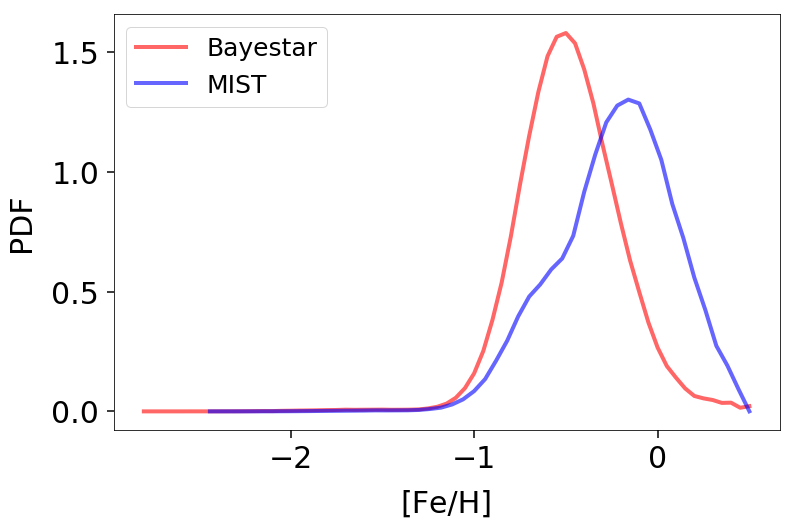

In [153]:
# plot metallicity distribution
plt.figure(figsize=(12, 8))
feh_bs, feh_bs_counts = np.unique(labels_bs['feh'][idxs_bs_gaia[good_bs_gaia]], 
                                  return_counts=True)
feh_mist, feh_mist_counts = np.unique(labels_mist['feh'][idxs_mist_gaia[sel_mist_gaia]], 
                                  return_counts=True)
plt.plot(feh_bs, feh_bs_counts / np.trapz(feh_bs_counts, feh_bs), 
         lw=4, color='red', alpha=0.6, label='Bayestar')
plt.plot(feh_mist, feh_mist_counts / np.trapz(feh_mist_counts, feh_mist), 
         lw=4, color='blue', alpha=0.6, label='MIST')
plt.xlabel('[Fe/H]')
plt.ylabel('PDF')
plt.legend(fontsize='small')
plt.tight_layout()